# Game Theory and Machine Learning Final Project

In this notebook, I tried to first produce the result of the "Adversarial Training for Free" paper for the MNIST dataset, by changing their own released code for imageNet dataset. Then I did few experiments for possible further improvements.

In [1]:
!pwd

/content


In [3]:
!git clone https://github.com/saba96/freeAdv.git

fatal: destination path 'freeAdv' already exists and is not an empty directory.


In [4]:
!mv ./freeAdv/* .

## Adversarial Traning for Free for MNIST

The following code is used to train models for different hyper-parameters. For training the saved models in this environment, I just set the hypyer-parameters few times and re-runned following cells.

First, let's import what we will need.

In [ ]:
import argparse
import logging
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable

Now, we can prepare our data and define the architecture we want to use for training our model.

In [ ]:
# Compose is used for chaining transfotmation, but here we only have one tranformation
"""ToTensor: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to 
a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]"""
T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
#!mkdir data
mnist_data = torchvision.datasets.MNIST('./data', train=True, transform=T, download=True)
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

def mnist_net():
    model = nn.Sequential(
        nn.Conv2d(1, 16, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(32*7*7,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    return model

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model = mnist_net().cuda()
model.train()

lr=.0001
opt = torch.optim.Adam(model.parameters(), lr=.0001)

In [ ]:
batch_size=100
total_epochs=1000
replays= 40
epochs = total_epochs / replays
attack='fgsm'
epsilon=0.3
alpha=0.01
attack_iters=40
lr_max=5e-3
lr_type='flat'
fname= '/content/mnist_model'
seed=0


In [ ]:
# It automatically converts NumPy arrays and Python numerical values into PyTorch Tensors.
# It outputs a dictionary with the same set of keys but batched Tensors as values 
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size, shuffle=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)

logger.info('Epoch \t Time \t LR \t \t Train Loss \t Train Acc')
global_noise_data = torch.zeros([batch_size, 1, 28, 28]).cuda()
for epoch in range(int(epochs)):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    # switch to the train mode
    model.train()
    for i, (X, y) in enumerate(train_loader):
        input, target = X.cuda(), y.cuda()
        for j in range(replays):

            # Ascend on the global noise
            noise_batch = Variable(global_noise_data[0:input.size(0)], requires_grad=True).cuda()
            in1 = input + noise_batch
            in1.clamp_(0, 1.0)
            output = model(in1)
            loss = criterion(output, target)

            # compute gradient
            opt.zero_grad()
            loss.backward()
            
            # Update the noise for the next iteration
            pert = alpha * torch.sign(noise_batch.grad)
            global_noise_data[0:input.size(0)] += pert.data
            global_noise_data.clamp_(-epsilon, epsilon)
          
            #finally do SGD step
            opt.step()
        train_loss += loss.item() * target.size(0)
        train_acc += (output.max(1)[1] == target).sum().item()
        train_n += target.size(0)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.4f \t %.4f',
        epoch, train_time - start_time, lr, train_loss/train_n, train_acc/train_n)
    model_name= '/content/mnist_model'+ str(total_epochs) + '_' + str(replays)
    torch.save(model.state_dict(),  model_name)

[2021/04/19 14:18:47] - Epoch 	 Time 	 LR 	 	 Train Loss 	 Train Acc
[2021/04/19 14:23:09] - 0 	 261.6 	 0.0001 	 0.0409 	 0.9930
[2021/04/19 14:27:31] - 1 	 261.9 	 0.0001 	 0.0048 	 1.0000
[2021/04/19 14:31:52] - 2 	 261.0 	 0.0001 	 0.0026 	 1.0000
[2021/04/19 14:36:13] - 3 	 260.8 	 0.0001 	 0.0017 	 1.0000
[2021/04/19 14:40:33] - 4 	 260.7 	 0.0001 	 0.0013 	 1.0000
[2021/04/19 14:44:54] - 5 	 260.7 	 0.0001 	 0.0010 	 1.0000
[2021/04/19 14:49:15] - 6 	 260.9 	 0.0001 	 0.0009 	 1.0000
[2021/04/19 14:53:36] - 7 	 260.7 	 0.0001 	 0.0007 	 1.0000
[2021/04/19 14:57:57] - 8 	 261.0 	 0.0001 	 0.0006 	 1.0000
[2021/04/19 15:02:17] - 9 	 260.1 	 0.0001 	 0.0004 	 1.0000


### Testing saved models

I trained 3 models, using 1000 total epochs with three different number of replays(10, 40, 100). Then I test them under the L-Infinity PGD attacks. I wrote my benchmark using advertorch. First we need to install advertorch.

In [ ]:
!pip install advertorch

     |████████████████████████████████| 5.7MB 6.2MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp37-none-any.whl size=5696220 sha256=3437b2697d3aecd9fa1e1cacebc5fa74416b19e1e9f014abbd41831a979b8ad4
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


Now, let's import what we will need.

In [ ]:
import pandas as pd
# importing advertorch
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks.utils import attack_whole_dataset

import matplotlib.pyplot as plt
%matplotlib inline

This bench mark is written using [advertorch](https://github.com/BorealisAI/advertorch). We first attack 3 models that we trained in the previous section(using 1000 total epochs with three different number of replays(10, 40, 100)). Then we visualize the result to understand it easier. Then we pick the best replays number to train our model with 100k total epochs in the next section. Please note that **m** refers to number of replays we used in the training mode for free adversarial training. Also, PGD-K here refers to L-Infinity PGD attack using K steps.

Accuracy: 99.02%, Robust Accuracy: 95.35%
Accuracy: 99.02%, Robust Accuracy: 93.66%
Accuracy: 99.02%, Robust Accuracy: 91.40%
Accuracy: 99.10%, Robust Accuracy: 97.54%
Accuracy: 99.10%, Robust Accuracy: 97.27%
Accuracy: 99.10%, Robust Accuracy: 97.11%
Accuracy: 98.79%, Robust Accuracy: 96.97%
Accuracy: 98.79%, Robust Accuracy: 96.48%
Accuracy: 98.79%, Robust Accuracy: 95.99%


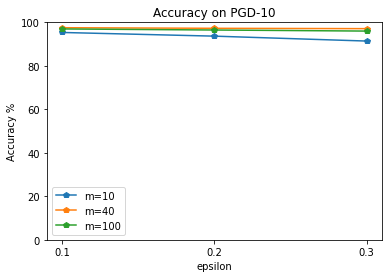

Accuracy: 99.02%, Robust Accuracy: 93.20%
Accuracy: 99.02%, Robust Accuracy: 63.50%
Accuracy: 99.02%, Robust Accuracy: 18.84%
Accuracy: 99.10%, Robust Accuracy: 96.99%
Accuracy: 99.10%, Robust Accuracy: 92.92%
Accuracy: 99.10%, Robust Accuracy: 86.79%
Accuracy: 98.79%, Robust Accuracy: 96.40%
Accuracy: 98.79%, Robust Accuracy: 90.51%
Accuracy: 98.79%, Robust Accuracy: 81.43%


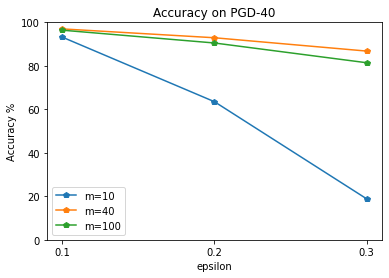

Accuracy: 99.02%, Robust Accuracy: 93.17%
Accuracy: 99.02%, Robust Accuracy: 56.40%
Accuracy: 99.02%, Robust Accuracy: 8.35%
Accuracy: 99.10%, Robust Accuracy: 97.03%
Accuracy: 99.10%, Robust Accuracy: 92.01%
Accuracy: 99.10%, Robust Accuracy: 79.31%
Accuracy: 98.79%, Robust Accuracy: 96.37%
Accuracy: 98.79%, Robust Accuracy: 89.76%
Accuracy: 98.79%, Robust Accuracy: 71.03%


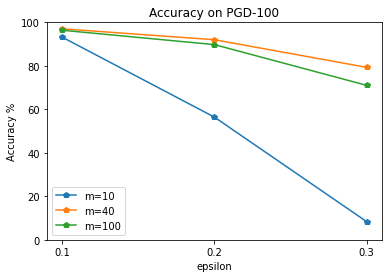

In [ ]:
pgd_report = []

# MNIST Test dataset and dataloader declaration
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=200, shuffle=True)

n_replays_list = [10, 40, 100]
attack_n_itrs_list = [10, 40, 100]
epsilons = [.1, .2, .3]
total_epochs = 1000
for attack_n_itrs in attack_n_itrs_list:
    fig, axis = plt.subplots()
    title = 'Accuracy on PGD-' + str(attack_n_itrs)
    axis.set_title(title, fontsize=12)
    for n_replay in n_replays_list:
        acc_list = []
        for epsilon in epsilons: 
            # Define what device we are using
            device = torch.device('cuda')
            # Load model and put it in evaluation mode
            path = '/content/mnist_model-' + str(total_epochs) + '_'+ str(n_replay)
            model = mnist_net().cuda()
            model.load_state_dict(torch.load(path))
            model.eval()

            adversary = LinfPGDAttack(
                model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
                nb_iter=attack_n_itrs, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
                targeted=False)

            _, label, pred, advpred = attack_whole_dataset(
                adversary, loader, device="cuda")
            
            clean_acc = 100. * (label == pred).sum().item() / len(label)
            adv_acc = 100. * (label == advpred).sum().item() / len(label)
            acc_list.append(adv_acc)
            pgd_report.append([total_epochs, n_replay, 'flat', 'LinfPGD', attack_n_itrs, epsilon, adv_acc, clean_acc])

            print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
                100. * (label == pred).sum().item() / len(label),
                100. * (label == advpred).sum().item() / len(label)))
        plt.plot(range(len(epsilons)), acc_list, marker='p', label='m=' + str(n_replay))
    
    axis.set_xlabel('epsilon')
    axis.set_ylabel('Accuracy %')
    axis.set_ylim(bottom=0)
    axis.set_ylim(top=100)
    plt.xticks(range(len(epsilons)),epsilons)
    axis.legend()
    plt.savefig('LinfPGD-' + str(attack_n_itrs))
    plt.show()

In [ ]:
column = ['total_epochs', 'replay', 'lr_type', 'attack_type', 'attack_n_itr', 'eps', 'adv_acc','clean_acc']
df = pd.DataFrame(pgd_report, columns= column)
df

,total_epochs,replay,lr_type,attack_type,attack_n_itr,eps,adv_acc,clean_acc
0,1000,10,flat,LinfPGD,10,0.1,95.35,99.02
1,1000,10,flat,LinfPGD,10,0.2,93.66,99.02
2,1000,10,flat,LinfPGD,10,0.3,91.40,99.02
3,1000,40,flat,LinfPGD,10,0.1,97.54,99.10
4,1000,40,flat,LinfPGD,10,0.2,97.27,99.10
5,1000,40,flat,LinfPGD,10,0.3,97.11,99.10
6,1000,100,flat,LinfPGD,10,0.1,96.97,98.79
7,1000,100,flat,LinfPGD,10,0.2,96.48,98.79
8,1000,100,flat,LinfPGD,10,0.3,95.99,98.79
9,1000,10,flat,LinfPGD,40,0.1,93.20,99.02


### Training Model with 100K Total Epochs

In this section, I trained a model with 100000 total epochs like Madry paper. I usded 40 as the number of replays, at it performed well for the smaller number of epochs. Also, I did checkpoint saving to continue from latest checkpoint when colab reached the limit. If you want to use the latest checkpoint you should change the **resume** to true. Also you can change the path if your checkpoint is saved elsewhere.

In [ ]:
batch_size=100
total_epochs=100000
replays= 40
epochs = total_epochs / replays
start_epoch = 0
epsilon=0.3
alpha=0.01
lr_type='flat'
fname= '/content/mnist_model'
seed=0
resume= True

# It automatically converts NumPy arrays and Python numerical values into PyTorch Tensors.
# It outputs a dictionary with the same set of keys but batched Tensors as values 
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size, shuffle=True)


if resume:
    path = '/content/mnist_model-latest_checkpoint-' + str(total_epochs) + '_' + str(replays)
    checkpoint = torch.load(path)
    model = mnist_net().cuda()
    lr=.0001
    opt = torch.optim.Adam(model.parameters(), lr=.0001)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    model.train()
else:
    print("No check point found! We train from the first epoch") 
    model = mnist_net().cuda()
    lr=.0001
    opt = torch.optim.Adam(model.parameters(), lr=.0001)
    start_epoch = 0
    model.train()

criterion = nn.CrossEntropyLoss()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)

logger.info('Epoch \t Time \t LR \t \t Train Loss \t Train Acc')
global_noise_data = torch.zeros([batch_size, 1, 28, 28]).cuda()
for epoch in range(start_epoch, int(epochs)):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    for i, (X, y) in enumerate(train_loader):
        input, target = X.cuda(), y.cuda()
        for j in range(replays):
            # Ascend on the global noise
            noise_batch = Variable(global_noise_data[0:input.size(0)], requires_grad=True).cuda()
            in1 = input + noise_batch
            in1.clamp_(0, 1.0)
            #in1.sub_(mean).div_(std)
            output = model(in1)
            loss = criterion(output, target)

            # compute gradient
            opt.zero_grad()
            loss.backward()
            
            # Update the noise for the next iteration
            pert = alpha * torch.sign(noise_batch.grad)
            global_noise_data[0:input.size(0)] += pert.data
            global_noise_data.clamp_(-epsilon, epsilon)
          
            #finally do SGD step
            opt.step()
            # measure elapsed time
            #batch_time.update(time.time() - end)
            #end = time.time()
        train_loss += loss.item() * target.size(0)
        train_acc += (output.max(1)[1] == target).sum().item()
        train_n += target.size(0)

    model_path = './mnist_model-latest_checkpoint-' + str(total_epochs) + '_' + str(replays)
    torch.save(model.state_dict(),  model_path)
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            }, model_path)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.6f \t %.4f',
        epoch, train_time - start_time, lr, train_loss/train_n, train_acc/train_n)

[2021/04/22 21:08:55] - Epoch 	 Time 	 LR 	 	 Train Loss 	 Train Acc
[2021/04/22 21:09:50] - 2465 	 55.1 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:10:45] - 2466 	 54.9 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:11:40] - 2467 	 54.8 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:12:35] - 2468 	 54.8 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:13:30] - 2469 	 54.8 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:14:25] - 2470 	 55.1 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:15:20] - 2471 	 55.1 	 0.0001 	 0.000006 	 1.0000
[2021/04/22 21:16:15] - 2472 	 55.5 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:17:11] - 2473 	 55.4 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:18:06] - 2474 	 55.6 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:19:02] - 2475 	 55.7 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:19:58] - 2476 	 55.6 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:20:53] - 2477 	 55.0 	 0.0001 	 0.000000 	 1.0000
[2021/04/22 21:21:47] - 2478 	 55.0 	 0.0001 	 0.000001 	 1.0000
[2021/04/22 21:22:42]

Now we test our robust model against different attacks, please note that I renamed the latest checkpoint manually.

In [ ]:
pgd_report = []

# MNIST Test dataset and dataloader declaration
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=200, shuffle=True)

n_replay = 40
attack_n_itrs_list = [10, 40, 100]
epsilons = [.1, .2, .3]
total_epochs = 100000
# Define what device we are using
device = torch.device('cuda')
# Load model and put it in evaluation mode
path = '/content/mnist_model-100000_40'
checkpoint = torch.load(path)
model = mnist_net().cuda()
opt = torch.optim.Adam(model.parameters(), lr=.0001)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()
for attack_n_itrs in attack_n_itrs_list:
    acc_list = []
    for epsilon in epsilons: 

        adversary = LinfPGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=attack_n_itrs, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
            targeted=False)

        _, label, pred, advpred = attack_whole_dataset(
            adversary, loader, device="cuda")
        
        clean_acc = 100. * (label == pred).sum().item() / len(label)
        adv_acc = 100. * (label == advpred).sum().item() / len(label)
        acc_list.append(adv_acc)
        pgd_report.append([total_epochs, n_replay, 'flat', 'LinfPGD', attack_n_itrs, epsilon, adv_acc, clean_acc])

        print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
            100. * (label == pred).sum().item() / len(label),
            100. * (label == advpred).sum().item() / len(label)))
column = ['total_epochs', 'replay', 'lr_type', 'attack_type', 'attack_n_itr', 'eps', 'adv_acc','clean_acc']
df = pd.DataFrame(pgd_report, columns= column)
df


Accuracy: 98.86%, Robust Accuracy: 98.31%
Accuracy: 98.86%, Robust Accuracy: 98.14%
Accuracy: 98.86%, Robust Accuracy: 98.11%
Accuracy: 98.86%, Robust Accuracy: 98.25%
Accuracy: 98.86%, Robust Accuracy: 98.18%
Accuracy: 98.86%, Robust Accuracy: 98.16%
Accuracy: 98.86%, Robust Accuracy: 98.21%
Accuracy: 98.86%, Robust Accuracy: 98.22%
Accuracy: 98.86%, Robust Accuracy: 98.11%


,total_epochs,replay,lr_type,attack_type,attack_n_itr,eps,adv_acc,clean_acc
0,100000,40,flat,LinfPGD,10,0.1,98.31,98.86
1,100000,40,flat,LinfPGD,10,0.2,98.14,98.86
2,100000,40,flat,LinfPGD,10,0.3,98.11,98.86
3,100000,40,flat,LinfPGD,40,0.1,98.25,98.86
4,100000,40,flat,LinfPGD,40,0.2,98.18,98.86
5,100000,40,flat,LinfPGD,40,0.3,98.16,98.86
6,100000,40,flat,LinfPGD,100,0.1,98.21,98.86
7,100000,40,flat,LinfPGD,100,0.2,98.22,98.86
8,100000,40,flat,LinfPGD,100,0.3,98.11,98.86


## Effect of Faster Convergence

In the extended-abstract, I explained I want use cyclic learning rate because it has been shown that it make the convergence rate faster. But during doing the experiment I observed that although convergence rate gets better, it actually worsen the robust accuracy. Also, I observed that batch-normalization made the robsut accuracy lower. After training and testing following model with 1000 total epochs, we use another strategy to make the model better. Please see the project report to see why faster convergence makes robust accuracy worser. 

### Cyclic Learning Rate

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size, shuffle=True)
# we use cyclic learning rate without normalization
model = mnist_net().cuda()
model.train()

opt = torch.optim.Adam(model.parameters(), lr=.0001)
lr_schedule = lambda t: np.interp([t], [0, epochs * 2//5, epochs], [0.0001,lr_max, 0])[0]

batch_size=100
total_epochs=1000
replays= 40
epochs = total_epochs / replays
epsilon=0.3
alpha=0.01
seed=0

criterion = nn.CrossEntropyLoss()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)

logger.info('Epoch \t Time \t LR \t \t Train Loss \t Train Acc')
global_noise_data = torch.zeros([batch_size, 1, 28, 28]).cuda()
for epoch in range(int(epochs)):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    # switch to the train mode
    model.train()
    for i, (X, y) in enumerate(train_loader):
        input, target = X.cuda(), y.cuda()
        lr = lr_schedule(epoch + (i+1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)
        for j in range(replays):

            # Ascend on the global noise
            noise_batch = Variable(global_noise_data[0:input.size(0)], requires_grad=True).cuda()
            in1 = input + noise_batch
            in1.clamp_(0, 1.0)
            in1.sub_(mean).div_(std)
            output = model(in1)
            loss = criterion(output, target)

            # compute gradient
            opt.zero_grad()
            loss.backward()
            
            # Update the noise for the next iteration
            pert = alpha * torch.sign(noise_batch.grad)
            global_noise_data[0:input.size(0)] += pert.data
            global_noise_data.clamp_(-epsilon, epsilon)
          
            #finally do SGD step
            opt.step()

        train_loss += loss.item() * target.size(0)
        train_acc += (output.max(1)[1] == target).sum().item()
        train_n += target.size(0)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.4f \t %.4f',
        epoch, train_time - start_time, lr, train_loss/train_n, train_acc/train_n)
    model_name= '/content/mnist_model-Cyclic-'+ str(total_epochs) + '_' + str(replays)
    torch.save(model.state_dict(),  model_name)

[2021/04/22 18:03:11] - Epoch 	 Time 	 LR 	 	 Train Loss 	 Train Acc
[2021/04/22 18:04:08] - 0 	 56.5 	 0.0006 	 0.1092 	 0.9684
[2021/04/22 18:05:04] - 1 	 56.6 	 0.0011 	 0.0021 	 1.0000
[2021/04/22 18:06:01] - 2 	 56.4 	 0.0016 	 0.0013 	 1.0000
[2021/04/22 18:06:57] - 3 	 56.5 	 0.0021 	 0.0014 	 0.9999
[2021/04/22 18:07:54] - 4 	 56.5 	 0.0025 	 0.0018 	 0.9996
[2021/04/22 18:08:52] - 5 	 58.0 	 0.0030 	 0.0027 	 0.9992
[2021/04/22 18:09:49] - 6 	 57.3 	 0.0035 	 0.0044 	 0.9988
[2021/04/22 18:10:47] - 7 	 57.5 	 0.0040 	 0.0102 	 0.9974
[2021/04/22 18:11:44] - 8 	 57.2 	 0.0045 	 0.0251 	 0.9936
[2021/04/22 18:12:41] - 9 	 57.2 	 0.0050 	 0.0493 	 0.9867
[2021/04/22 18:13:38] - 10 	 56.8 	 0.0047 	 0.0826 	 0.9793
[2021/04/22 18:14:35] - 11 	 57.2 	 0.0043 	 0.1028 	 0.9729
[2021/04/22 18:15:32] - 12 	 57.1 	 0.0040 	 0.1104 	 0.9703
[2021/04/22 18:16:29] - 13 	 56.9 	 0.0037 	 0.1206 	 0.9688
[2021/04/22 18:17:26] - 14 	 57.1 	 0.0033 	 0.1307 	 0.9664
[2021/04/22 18:18:23] - 15

Now we test the trained model with cyclic learning rate.

In [ ]:
pgd_report = []

# MNIST Test dataset and dataloader declaration
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=200, shuffle=True)

n_replay = 40
attack_n_itrs_list = [10, 40, 100]
epsilons = [.1, .2, .3]
total_epochs = 1000
# load the model and put it in evaluation mode
model = mnist_net().cuda()
model.load_state_dict(torch.load('/content/mnist_model-Cyclic-1000_40'))
model.eval()

for attack_n_itrs in attack_n_itrs_list:
    acc_list = []
    for epsilon in epsilons: 

        adversary = LinfPGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=attack_n_itrs, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
            targeted=False)

        _, label, pred, advpred = attack_whole_dataset(
            adversary, loader, device="cuda")
        
        clean_acc = 100. * (label == pred).sum().item() / len(label)
        adv_acc = 100. * (label == advpred).sum().item() / len(label)
        acc_list.append(adv_acc)
        pgd_report.append([total_epochs, n_replay, 'cyclic', 'LinfPGD', attack_n_itrs, epsilon, adv_acc, clean_acc])

        print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
            100. * (label == pred).sum().item() / len(label),
            100. * (label == advpred).sum().item() / len(label)))
column = ['total_epochs', 'replay', 'lr_type', 'attack_type', 'attack_n_itr', 'eps', 'adv_acc','clean_acc']
df = pd.DataFrame(pgd_report, columns= column)
df

Accuracy: 94.46%, Robust Accuracy: 66.60%
Accuracy: 94.46%, Robust Accuracy: 51.98%
Accuracy: 94.46%, Robust Accuracy: 39.49%
Accuracy: 94.46%, Robust Accuracy: 58.85%
Accuracy: 94.46%, Robust Accuracy: 14.34%
Accuracy: 94.46%, Robust Accuracy: 1.92%
Accuracy: 94.46%, Robust Accuracy: 58.71%
Accuracy: 94.46%, Robust Accuracy: 11.77%
Accuracy: 94.46%, Robust Accuracy: 0.91%


,total_epochs,replay,lr_type,attack_type,attack_n_itr,eps,adv_acc,clean_acc
0,1000,40,flat,LinfPGD,10,0.1,66.60,94.46
1,1000,40,flat,LinfPGD,10,0.2,51.98,94.46
2,1000,40,flat,LinfPGD,10,0.3,39.49,94.46
3,1000,40,flat,LinfPGD,40,0.1,58.85,94.46
4,1000,40,flat,LinfPGD,40,0.2,14.34,94.46
5,1000,40,flat,LinfPGD,40,0.3,1.92,94.46
6,1000,40,flat,LinfPGD,100,0.1,58.71,94.46
7,1000,40,flat,LinfPGD,100,0.2,11.77,94.46
8,1000,40,flat,LinfPGD,100,0.3,0.91,94.46


## Improving Model Using Curriculum Learning



### 1000 total epochs



In [ ]:
# It automatically converts NumPy arrays and Python numerical values into PyTorch Tensors.
# It outputs a dictionary with the same set of keys but batched Tensors as values 
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size, shuffle=True)

model = mnist_net().cuda()
model.train()

lr=.0001
opt = torch.optim.Adam(model.parameters(), lr=.0001)

batch_size=100
total_epochs=1000
replays= 40
epochs = total_epochs / replays
epsilon=0.3
alpha=0.01
lr_max=5e-3
lr_type='cyclic'
seed=0

criterion = nn.CrossEntropyLoss()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)

logger.info('Epoch \t Time \t LR \t \t Train Loss \t Train Acc')
global_noise_data = torch.zeros([batch_size, 1, 28, 28]).cuda()
lr_schedule = lambda t: np.interp([t], [0, epochs * 2//5, epochs], [0, lr_max, 0])[0]
for epoch in range(int(epochs)):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    mean = 0.1307
    std= 0.3081
    # switch to the train mode
    model.train()
    if epoch < (epochs/ 4):
        alpha = .1
    elif epoch < (epochs/ 2):
        alpha = .2
    else:
        alpha = .3

    for i, (X, y) in enumerate(train_loader):
        input, target = X.cuda(), y.cuda()
        lr = lr_schedule(epoch + (i+1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)
        for j in range(replays):

            # Ascend on the global noise
            noise_batch = Variable(global_noise_data[0:input.size(0)], requires_grad=True).cuda()
            in1 = input + noise_batch
            in1.clamp_(0, 1.0)
            output = model(in1)
            loss = criterion(output, target)

            # compute gradient
            opt.zero_grad()
            loss.backward()
            
            # Update the noise for the next iteration
            pert = alpha * torch.sign(noise_batch.grad)
            global_noise_data[0:input.size(0)] += pert.data
            global_noise_data.clamp_(-epsilon, epsilon)
          
            #finally do SGD step
            opt.step()

        train_loss += loss.item() * target.size(0)
        train_acc += (output.max(1)[1] == target).sum().item()
        train_n += target.size(0)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.4f \t %.4f',
        epoch, train_time - start_time, lr, train_loss/train_n, train_acc/train_n)
    model_name= '/content/mnist_model-improved-'+ str(total_epochs) + '_' + str(replays)
    torch.save(model.state_dict(),  model_name)

[2021/04/22 17:27:47] - Epoch 	 Time 	 LR 	 	 Train Loss 	 Train Acc
[2021/04/22 17:28:43] - 0 	 56.1 	 0.0005 	 0.3380 	 0.8931
[2021/04/22 17:29:39] - 1 	 56.0 	 0.0010 	 0.0058 	 0.9999
[2021/04/22 17:30:35] - 2 	 56.2 	 0.0015 	 0.0047 	 0.9999
[2021/04/22 17:31:30] - 3 	 55.5 	 0.0020 	 0.0061 	 0.9998
[2021/04/22 17:32:26] - 4 	 55.5 	 0.0025 	 0.0071 	 0.9993
[2021/04/22 17:33:21] - 5 	 55.0 	 0.0030 	 0.0107 	 0.9983
[2021/04/22 17:34:16] - 6 	 55.3 	 0.0035 	 0.0390 	 0.9909
[2021/04/22 17:35:12] - 7 	 55.6 	 0.0040 	 0.0238 	 0.9960
[2021/04/22 17:36:08] - 8 	 56.0 	 0.0045 	 0.0265 	 0.9949
[2021/04/22 17:37:04] - 9 	 55.8 	 0.0050 	 0.0321 	 0.9927
[2021/04/22 17:37:59] - 10 	 55.5 	 0.0047 	 0.0696 	 0.9817
[2021/04/22 17:38:55] - 11 	 55.8 	 0.0043 	 0.0653 	 0.9839
[2021/04/22 17:39:51] - 12 	 55.6 	 0.0040 	 0.0599 	 0.9859
[2021/04/22 17:40:46] - 13 	 55.8 	 0.0037 	 0.0237 	 0.9957
[2021/04/22 17:41:42] - 14 	 55.5 	 0.0033 	 0.0203 	 0.9957
[2021/04/22 17:42:37] - 15

In [ ]:
pgd_report = []

# MNIST Test dataset and dataloader declaration
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=200, shuffle=True)

n_replay = 40
attack_n_itrs_list = [10, 40, 100]
epsilons = [.1, .2, .3]
total_epochs = 1000
# load the model and put it in evaluation mode
model = mnist_net().cuda()
model.load_state_dict(torch.load('/content/mnist_model-improved-1000_40'))
model.eval()

for attack_n_itrs in attack_n_itrs_list:
    acc_list = []
    for epsilon in epsilons: 

        adversary = LinfPGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=attack_n_itrs, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
            targeted=False)

        _, label, pred, advpred = attack_whole_dataset(
            adversary, loader, device="cuda")
        
        clean_acc = 100. * (label == pred).sum().item() / len(label)
        adv_acc = 100. * (label == advpred).sum().item() / len(label)
        acc_list.append(adv_acc)
        pgd_report.append([total_epochs, n_replay, 'cyclic', 'LinfPGD', attack_n_itrs, epsilon, adv_acc, clean_acc])

        print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
            100. * (label == pred).sum().item() / len(label),
            100. * (label == advpred).sum().item() / len(label)))
column = ['total_epochs', 'replay', 'lr_type', 'attack_type', 'attack_n_itr', 'eps', 'adv_acc','clean_acc']
df = pd.DataFrame(pgd_report, columns= column)
df

Accuracy: 97.33%, Robust Accuracy: 95.04%
Accuracy: 97.33%, Robust Accuracy: 94.34%
Accuracy: 97.33%, Robust Accuracy: 93.75%
Accuracy: 97.33%, Robust Accuracy: 94.41%
Accuracy: 97.33%, Robust Accuracy: 91.07%
Accuracy: 97.33%, Robust Accuracy: 86.69%
Accuracy: 97.33%, Robust Accuracy: 94.51%
Accuracy: 97.33%, Robust Accuracy: 90.74%
Accuracy: 97.33%, Robust Accuracy: 84.52%


,total_epochs,replay,lr_type,attack_type,attack_n_itr,eps,adv_acc,clean_acc
0,1000,40,flat,LinfPGD,10,0.1,95.04,97.33
1,1000,40,flat,LinfPGD,10,0.2,94.34,97.33
2,1000,40,flat,LinfPGD,10,0.3,93.75,97.33
3,1000,40,flat,LinfPGD,40,0.1,94.41,97.33
4,1000,40,flat,LinfPGD,40,0.2,91.07,97.33
5,1000,40,flat,LinfPGD,40,0.3,86.69,97.33
6,1000,40,flat,LinfPGD,100,0.1,94.51,97.33
7,1000,40,flat,LinfPGD,100,0.2,90.74,97.33
8,1000,40,flat,LinfPGD,100,0.3,84.52,97.33


### 2000 total epochs

In [ ]:
# It automatically converts NumPy arrays and Python numerical values into PyTorch Tensors.
# It outputs a dictionary with the same set of keys but batched Tensors as values 
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size, shuffle=True)

model = mnist_net().cuda()
model.train()

lr=.0001
opt = torch.optim.Adam(model.parameters(), lr=.0001)

batch_size=100
total_epochs=2000
replays= 40
epochs = total_epochs / replays
epsilon=0.3
alpha=0.01
lr_max=5e-3
lr_type='cyclic'
seed=0

criterion = nn.CrossEntropyLoss()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)

logger.info('Epoch \t Time \t LR \t \t Train Loss \t Train Acc')
global_noise_data = torch.zeros([batch_size, 1, 28, 28]).cuda()
lr_schedule = lambda t: np.interp([t], [0, epochs * 2//5, epochs], [0, lr_max, 0])[0]
for epoch in range(int(epochs)):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    if epoch < (epochs/ 4):
        alpha = .1
    elif epoch < (epochs/ 2):
        alpha = .2
    else:
        alpha = .3
    
    for i, (X, y) in enumerate(train_loader):
        input, target = X.cuda(), y.cuda()
        lr = lr_schedule(epoch + (i+1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)
        for j in range(replays):

            # Ascend on the global noise
            noise_batch = Variable(global_noise_data[0:input.size(0)], requires_grad=True).cuda()
            in1 = input + noise_batch
            in1.clamp_(0, 1.0)
            #in1.sub_(mean).div_(std)
            output = model(in1)
            loss = criterion(output, target)

            # compute gradient
            opt.zero_grad()
            loss.backward()
            
            # Update the noise for the next iteration
            pert = alpha * torch.sign(noise_batch.grad)
            global_noise_data[0:input.size(0)] += pert.data
            global_noise_data.clamp_(-epsilon, epsilon)
          
            #finally do SGD step
            opt.step()

        train_loss += loss.item() * target.size(0)
        train_acc += (output.max(1)[1] == target).sum().item()
        train_n += target.size(0)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.4f \t %.4f',
        epoch, train_time - start_time, lr, train_loss/train_n, train_acc/train_n)
    model_name= '/content/mnist_model-improved-'+ str(total_epochs) + '_' + str(replays)
    torch.save(model.state_dict(),  model_name)

[2021/04/22 20:11:27] - Epoch 	 Time 	 LR 	 	 Train Loss 	 Train Acc
[2021/04/22 20:12:24] - 0 	 56.2 	 0.0003 	 0.4905 	 0.8405
[2021/04/22 20:13:19] - 1 	 55.7 	 0.0005 	 0.0172 	 0.9996
[2021/04/22 20:14:15] - 2 	 55.5 	 0.0008 	 0.0053 	 1.0000
[2021/04/22 20:15:10] - 3 	 55.5 	 0.0010 	 0.0037 	 0.9999
[2021/04/22 20:16:06] - 4 	 55.6 	 0.0013 	 0.0033 	 0.9999
[2021/04/22 20:17:01] - 5 	 55.2 	 0.0015 	 0.0030 	 1.0000
[2021/04/22 20:17:57] - 6 	 55.7 	 0.0018 	 0.0038 	 0.9997
[2021/04/22 20:18:53] - 7 	 55.8 	 0.0020 	 0.0050 	 0.9994
[2021/04/22 20:19:48] - 8 	 55.4 	 0.0023 	 0.0076 	 0.9990
[2021/04/22 20:20:44] - 9 	 56.0 	 0.0025 	 0.0237 	 0.9957
[2021/04/22 20:21:40] - 10 	 55.7 	 0.0027 	 0.0305 	 0.9938
[2021/04/22 20:22:35] - 11 	 55.7 	 0.0030 	 0.0347 	 0.9923
[2021/04/22 20:23:31] - 12 	 55.6 	 0.0033 	 0.0354 	 0.9923
[2021/04/22 20:24:27] - 13 	 55.7 	 0.0035 	 0.0246 	 0.9952
[2021/04/22 20:25:22] - 14 	 55.5 	 0.0037 	 0.0246 	 0.9953
[2021/04/22 20:26:18] - 15

In [ ]:
pgd_report = []

# MNIST Test dataset and dataloader declaration
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=200, shuffle=True)

n_replay = 40
attack_n_itrs_list = [10, 40, 100]
epsilons = [.1, .2, .3]
total_epochs = 2000
# load the model and put it in evaluation mode
model = mnist_net().cuda()
model.load_state_dict(torch.load('/content/mnist_model-improved-2000_40'))
model.eval()

for attack_n_itrs in attack_n_itrs_list:
    acc_list = []
    for epsilon in epsilons: 

        adversary = LinfPGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=attack_n_itrs, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
            targeted=False)

        _, label, pred, advpred = attack_whole_dataset(
            adversary, loader, device="cuda")
        
        clean_acc = 100. * (label == pred).sum().item() / len(label)
        adv_acc = 100. * (label == advpred).sum().item() / len(label)
        acc_list.append(adv_acc)
        pgd_report.append([total_epochs, n_replay, 'cyclic', 'LinfPGD', attack_n_itrs, epsilon, adv_acc, clean_acc])

        print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
            100. * (label == pred).sum().item() / len(label),
            100. * (label == advpred).sum().item() / len(label)))
column = ['total_epochs', 'replay', 'lr_type', 'attack_type', 'attack_n_itr', 'eps', 'adv_acc','clean_acc']
df = pd.DataFrame(pgd_report, columns= column)
df

Accuracy: 97.20%, Robust Accuracy: 96.03%
Accuracy: 97.20%, Robust Accuracy: 95.52%
Accuracy: 97.20%, Robust Accuracy: 95.34%
Accuracy: 97.20%, Robust Accuracy: 95.77%
Accuracy: 97.20%, Robust Accuracy: 94.25%
Accuracy: 97.20%, Robust Accuracy: 92.11%
Accuracy: 97.20%, Robust Accuracy: 95.64%
Accuracy: 97.20%, Robust Accuracy: 93.97%
Accuracy: 97.20%, Robust Accuracy: 91.18%


,total_epochs,replay,lr_type,attack_type,attack_n_itr,eps,adv_acc,clean_acc
0,2000,40,flat,LinfPGD,10,0.1,96.03,97.2
1,2000,40,flat,LinfPGD,10,0.2,95.52,97.2
2,2000,40,flat,LinfPGD,10,0.3,95.34,97.2
3,2000,40,flat,LinfPGD,40,0.1,95.77,97.2
4,2000,40,flat,LinfPGD,40,0.2,94.25,97.2
5,2000,40,flat,LinfPGD,40,0.3,92.11,97.2
6,2000,40,flat,LinfPGD,100,0.1,95.64,97.2
7,2000,40,flat,LinfPGD,100,0.2,93.97,97.2
8,2000,40,flat,LinfPGD,100,0.3,91.18,97.2


## Some Visualization

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import argparse
import torch
import torch.nn as nn

from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Adversarial for Free with 100k epochs

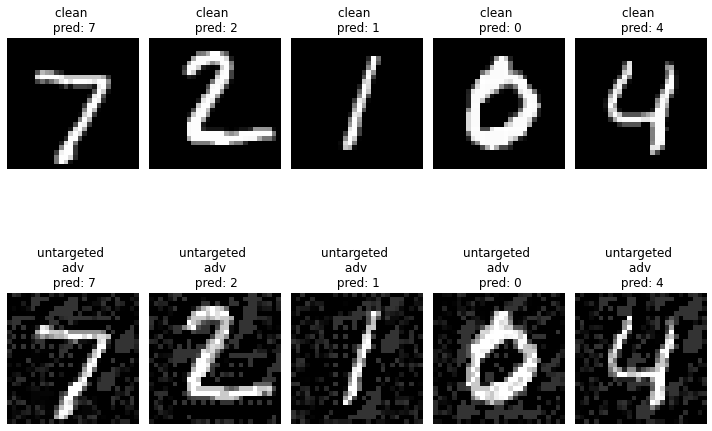

In [ ]:
# Load model and put it in evaluation mode
path = '/content/mnist_model-100000_40'
checkpoint = torch.load(path)
model = mnist_net().cuda()
opt = torch.optim.Adam(model.parameters(), lr=.0001)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()
batch_size = 5
loader = get_mnist_test_loader(batch_size=batch_size)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)
adv_untargeted = adversary.perturb(cln_data, true_label)
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(2, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))

plt.tight_layout()
plt.show()

### Imroved with Curriculum Learning

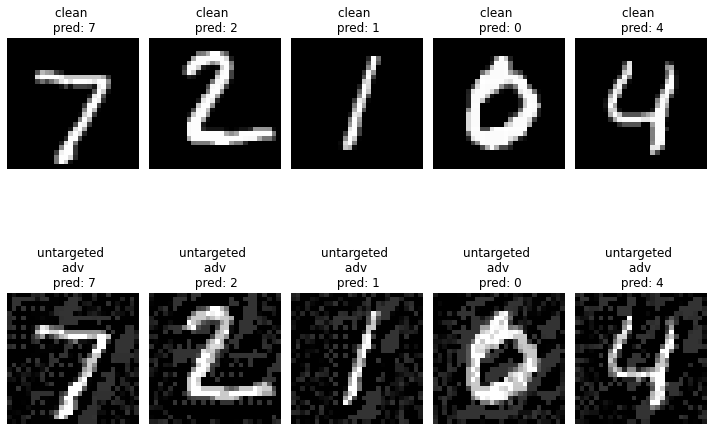

In [ ]:
# load the model and put it in evaluation mode
model = mnist_net().cuda()
model.load_state_dict(torch.load('/content/mnist_model-improved-2000_40'))
model.eval()
batch_size = 5
loader = get_mnist_test_loader(batch_size=batch_size)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)
adv_untargeted = adversary.perturb(cln_data, true_label)
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(2, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))

plt.tight_layout()
plt.show()

## Catastrophic Forgetting!

Authors suggest that catastrophic forgetting can happen in some extreme cases where informative images of one class are in first minibatches. Therefore, model does not consider it in updating weights anymore. In the extended abstract I sugested that this can be improved by faster convergence rate which leads to less training steps.


To check if the final model trained by mixture of free adversarial training, cyclic learning rate and curriculm learning is improved in such a case, I did this expermint.

First, we need a trainloader that have the same images of only one class in first minibatches and then shows other images to our model in the training phase. Well, catastrophic forgetting stills a problem when all informative images of one class is just in first minibatches.


In [ ]:
T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# in case you don't have the data change download to True
dataset = torchvision.datasets.MNIST('./data', train=True, transform=T, download=False)
idx = dataset.targets==1
dataset.targets = dataset.targets[idx]
dataset.data = dataset.data[idx]
data_one = dataset

In [ ]:
T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
# in case you don't have the data change download to True
dataset = torchvision.datasets.MNIST('./data', train=True, transform=T, download=False)
idx = dataset.targets!=1
dataset.targets = dataset.targets[idx]
dataset.data = dataset.data[idx]
data_other = dataset

In [ ]:
new_mnist = torch.utils.data.ConcatDataset([data_one, data_other])
new_mnist

In [ ]:
train_loader = torch.utils.data.DataLoader(new_mnist, batch_size=100, shuffle=False)

In case to see batch orders. I just printed two batch for keeping it short, but I checked it myslef.

In [ ]:
for i, (X, y) in enumerate(train_loader):
    input, target = X.cuda(), y.cuda()
    if(i==0):
        print(target)
    if(i==200):
        print(target)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], device='cuda:0')
tensor([3, 0, 2, 4, 6, 8, 9, 0, 5, 4, 0, 9, 5, 6, 7, 5, 9, 4, 0, 6, 7, 2, 6, 0,
        4, 8, 7, 5, 0, 4, 6, 9, 8, 4, 9, 2, 5, 4, 9, 7, 9, 9, 8, 9, 6, 4, 0, 8,
        5, 2, 7, 7, 5, 3, 6, 2, 6, 3, 3, 3, 4, 5, 2, 3, 0, 2, 0, 9, 7, 8, 3, 4,
        5, 6, 4, 0, 9, 2, 3, 6, 8, 4, 6, 7, 4, 2, 2, 5, 0, 6, 3, 0, 6, 9, 8, 6,
        3, 3, 5, 2], device='cuda:0')


In [ ]:
model = mnist_net().cuda()
model.train()

lr=.0001
opt = torch.optim.Adam(model.parameters(), lr=.0001)

batch_size=100
total_epochs=2000
replays= 40
epochs = total_epochs / replays
epsilon=0.3
alpha=0.01
lr_max=5e-3
lr_type='cyclic'
seed=0

criterion = nn.CrossEntropyLoss()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format='[%(asctime)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)

logger.info('Epoch \t Time \t LR \t \t Train Loss \t Train Acc')
global_noise_data = torch.zeros([batch_size, 1, 28, 28]).cuda()
lr_schedule = lambda t: np.interp([t], [0, epochs * 2//5, epochs], [0, lr_max, 0])[0]
for epoch in range(int(epochs)):
    start_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    if epoch < (epochs/ 4):
        alpha = .1
    elif epoch < (epochs/ 2):
        alpha = .2
    else:
        alpha = .3
    
    for i, (X, y) in enumerate(train_loader):
        input, target = X.cuda(), y.cuda()
        lr = lr_schedule(epoch + (i+1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)
        for j in range(replays):

            # Ascend on the global noise
            noise_batch = Variable(global_noise_data[0:input.size(0)], requires_grad=True).cuda()
            in1 = input + noise_batch
            in1.clamp_(0, 1.0)
            #in1.sub_(mean).div_(std)
            output = model(in1)
            loss = criterion(output, target)

            # compute gradient
            opt.zero_grad()
            loss.backward()
            
            # Update the noise for the next iteration
            pert = alpha * torch.sign(noise_batch.grad)
            global_noise_data[0:input.size(0)] += pert.data
            global_noise_data.clamp_(-epsilon, epsilon)
          
            #finally do SGD step
            opt.step()

        train_loss += loss.item() * target.size(0)
        train_acc += (output.max(1)[1] == target).sum().item()
        train_n += target.size(0)

    train_time = time.time()
    logger.info('%d \t %.1f \t %.4f \t %.4f \t %.4f',
        epoch, train_time - start_time, lr, train_loss/train_n, train_acc/train_n)
    model_name= '/content/mnist_model-catasCheck-'+ str(total_epochs) + '_' + str(replays)
    torch.save(model.state_dict(),  model_name)

[2021/04/29 16:12:03] - Epoch 	 Time 	 LR 	 	 Train Loss 	 Train Acc
[2021/04/29 16:13:18] - 0 	 75.7 	 0.0003 	 0.4381 	 0.8719
[2021/04/29 16:14:34] - 1 	 75.7 	 0.0005 	 0.0148 	 0.9993
[2021/04/29 16:15:50] - 2 	 75.7 	 0.0008 	 0.0047 	 0.9999
[2021/04/29 16:17:05] - 3 	 75.7 	 0.0010 	 0.0029 	 1.0000
[2021/04/29 16:18:21] - 4 	 75.8 	 0.0013 	 0.0025 	 0.9998
[2021/04/29 16:19:37] - 5 	 75.6 	 0.0015 	 0.0021 	 0.9999
[2021/04/29 16:20:53] - 6 	 75.8 	 0.0018 	 0.0046 	 0.9998
[2021/04/29 16:22:08] - 7 	 75.4 	 0.0020 	 0.0289 	 0.9950
[2021/04/29 16:23:23] - 8 	 75.2 	 0.0023 	 0.1162 	 0.9660
[2021/04/29 16:24:38] - 9 	 75.1 	 0.0025 	 0.0808 	 0.9788
[2021/04/29 16:25:54] - 10 	 75.3 	 0.0027 	 0.0712 	 0.9816
[2021/04/29 16:27:09] - 11 	 74.9 	 0.0030 	 0.0696 	 0.9820
[2021/04/29 16:28:24] - 12 	 75.6 	 0.0033 	 0.0661 	 0.9825
[2021/04/29 16:29:40] - 13 	 75.3 	 0.0035 	 0.0542 	 0.9873
[2021/04/29 16:30:55] - 14 	 75.4 	 0.0037 	 0.0483 	 0.9888
[2021/04/29 16:32:10] - 15

In [ ]:
import pandas as pd
# importing advertorch
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks.utils import attack_whole_dataset

pgd_report = []

# MNIST Test dataset and dataloader declaration
loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=200, shuffle=True)

n_replay = 40
attack_n_itrs_list = [10, 40, 100]
epsilons = [.1, .2, .3]
total_epochs = 2000
# load the model and put it in evaluation mode
model = mnist_net().cuda()
model.load_state_dict(torch.load('/content/mnist_model-catasCheck-2000_40'))
model.eval()

for attack_n_itrs in attack_n_itrs_list:
    acc_list = []
    for epsilon in epsilons: 

        adversary = LinfPGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=attack_n_itrs, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
            targeted=False)

        _, label, pred, advpred = attack_whole_dataset(
            adversary, loader, device="cuda")
        
        clean_acc = 100. * (label == pred).sum().item() / len(label)
        adv_acc = 100. * (label == advpred).sum().item() / len(label)
        acc_list.append(adv_acc)
        pgd_report.append([total_epochs, n_replay, 'cyclic', 'LinfPGD', attack_n_itrs, epsilon, adv_acc, clean_acc])

        print("Accuracy: {:.2f}%, Robust Accuracy: {:.2f}%".format(
            100. * (label == pred).sum().item() / len(label),
            100. * (label == advpred).sum().item() / len(label)))
column = ['total_epochs', 'replay', 'lr_type', 'attack_type', 'attack_n_itr', 'eps', 'adv_acc','clean_acc']
df = pd.DataFrame(pgd_report, columns= column)
df

Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%
Accuracy: 10.28%, Robust Accuracy: 10.28%


,total_epochs,replay,lr_type,attack_type,attack_n_itr,eps,adv_acc,clean_acc
0,2000,40,cyclic,LinfPGD,10,0.1,10.28,10.28
1,2000,40,cyclic,LinfPGD,10,0.2,10.28,10.28
2,2000,40,cyclic,LinfPGD,10,0.3,10.28,10.28
3,2000,40,cyclic,LinfPGD,40,0.1,10.28,10.28
4,2000,40,cyclic,LinfPGD,40,0.2,10.28,10.28
5,2000,40,cyclic,LinfPGD,40,0.3,10.28,10.28
6,2000,40,cyclic,LinfPGD,100,0.1,10.28,10.28
7,2000,40,cyclic,LinfPGD,100,0.2,10.28,10.28
8,2000,40,cyclic,LinfPGD,100,0.3,10.28,10.28


## Refrences

https://github.com/mahyarnajibi/FreeAdversarialTraining

https://github.com/BorealisAI/advertorch

https://github.com/locuslab/fast_adversarial